# First very rough try at Gaussian process through Earth-Moon data

by *Niels J. de Winter* **n.j.de.winter@vu.nl**

In [21]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv, cholesky, solve
from scipy.optimize import minimize

## Input manually estimated data based on Williams et al. (2000)

In [7]:
# Manually estimated data with rough error bars from the Figure 2 in Williams et al. (2000)
data = [
    {"Age (Ma)": 620, "Days/year": 400, "Days/year error": 10, "Hours/day": 22.0, "Hours/day error": 0.4, "Data type": "Elatina–Reynella"},
    {"Age (Ma)": 600, "Days/year": 410, "Days/year error": 10, "Hours/day": 21.4, "Hours/day error": 0.3, "Data type": "Stromatolites, max"},
    {"Age (Ma)": 550, "Days/year": 417, "Days/year error": 5, "Hours/day": 21.0, "Hours/day error": 0.2, "Data type": "Stromatolites, mean"},
    {"Age (Ma)": 500, "Days/year": 415, "Days/year error": 5, "Hours/day": 21.1, "Hours/day error": 0.2, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 450, "Days/year": 410, "Days/year error": 5, "Hours/day": 21.3, "Hours/day error": 0.2, "Data type": "Bivalves, mean"},
    {"Age (Ma)": 400, "Days/year": 400, "Days/year error": 5, "Hours/day": 22.0, "Hours/day error": 0.2, "Data type": "Corals, max"},
    {"Age (Ma)": 380, "Days/year": 395, "Days/year error": 10, "Hours/day": 22.2, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 300, "Days/year": 385, "Days/year error": 10, "Hours/day": 22.6, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 250, "Days/year": 375, "Days/year error": 10, "Hours/day": 23.3, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 150, "Days/year": 370, "Days/year error": 10, "Hours/day": 23.5, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 0, "Days/year": 365.25, "Days/year error": 0, "Hours/day": 24.0, "Hours/day error": 0, "Data type": "Modern value"},
]

df = pd.DataFrame(data)
df.head()

,Age (Ma),Days/year,Days/year error,Hours/day,Hours/day error,Data type
0,620,400.0,10,22.0,0.4,Elatina–Reynella
1,600,410.0,10,21.4,0.3,"Stromatolites, max"
2,550,417.0,5,21.0,0.2,"Stromatolites, mean"
3,500,415.0,5,21.1,0.2,"Brachiopods, max"
4,450,410.0,5,21.3,0.2,"Bivalves, mean"


## Plot dummy data

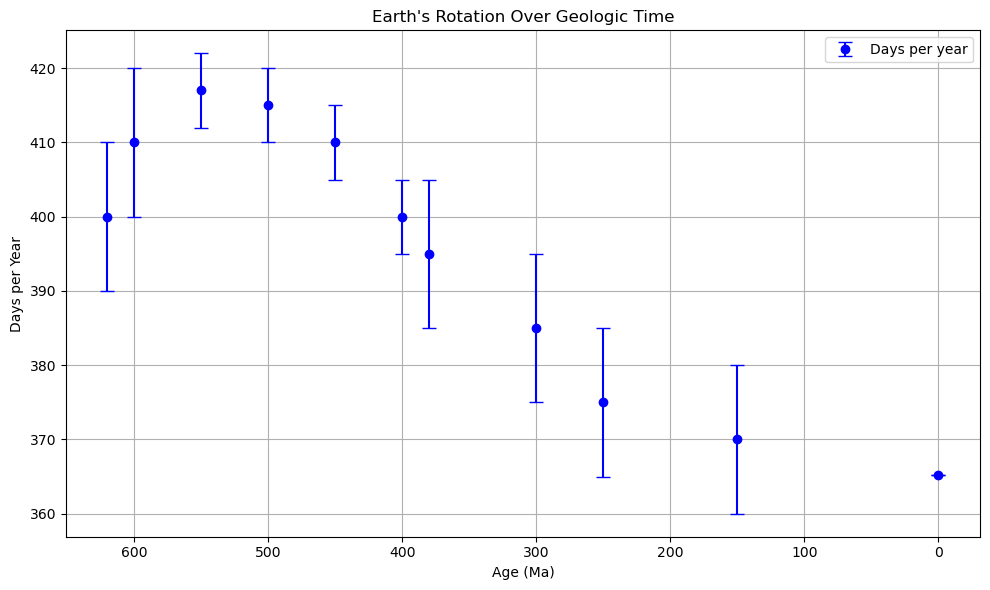

In [12]:
# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(df["Age (Ma)"], df["Days/year"], yerr=df["Days/year error"],
             fmt='o', color='blue', capsize=5, label="Days per year")

# Invert x-axis (oldest on left)
plt.gca().invert_xaxis()

# Labels and title
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Test: play around with Gaussian process regression

### Use Radial Basis Function as kernel
Based on https://medium.com/data-science-at-microsoft/introduction-to-gaussian-process-regression-part-1-the-basics-3cb79d9f155f#b578

Script to play around with hyperparameters without optimization

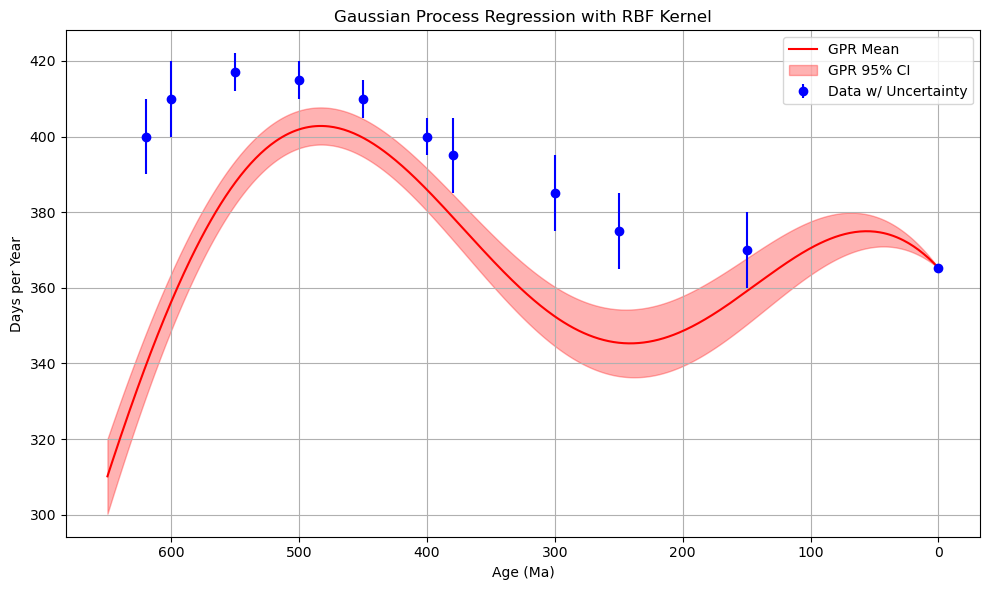

In [20]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
y_train = df["Days/year"].values.astype(float)
y_error = df["Days/year error"].values.astype(float)

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std

# 2. Define RBF kernel function
def rbf_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """Radial Basis Function (RBF) kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + \
             np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

# 3. Set hyperparameters
lengthscale = 1.0  # Lengthscale of the RBF kernel
variance = 100.0

# 4. Compute kernel matrices
K = rbf_kernel(X_train_norm, X_train_norm, lengthscale, variance) # Covariance matrix
K += np.diag((y_error**2))  # Add individual noise variances
K_inv = inv(K) # Inverse of covariance matrix

# 5. Predict on new input grid
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
K_s = rbf_kernel(X_test_norm, X_train_norm, lengthscale, variance) # Cross-covariance between test and training data
K_ss = rbf_kernel(X_test_norm, X_test_norm, lengthscale, variance) + 1e-8 * np.eye(len(X_test)) # Covariance matrix for test data (adding small noise for numerical stability)

# 6. Posterior mean and covariance
mu_s = K_s @ K_inv @ y_train # Mean prediction
cov_s = K_ss - K_s @ K_inv @ K_s.T # Covariance of the prediction
std_s = np.sqrt(np.diag(cov_s)) # Standard deviation of the prediction

# 7. Plot
plt.figure(figsize=(10, 6))
plt.errorbar(X_train, y_train, yerr=y_error.flatten(), fmt='o', color='blue', label='Data w/ Uncertainty')
plt.plot(X_test, mu_s, 'r', label="GPR Mean")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='GPR 95% CI')
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.gca().invert_xaxis()
plt.title("Gaussian Process Regression with RBF Kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Optimize hyperparameters

In [ ]:
# Negative Log Marginal Likelihood
def nlml(params):
    lengthscale = np.exp(params[0])  # log-param to ensure positivity
    variance = np.exp(params[1])
    noise_var = (y_err ** 2).flatten()

    K = rbf_kernel(X_train_norm, X_train_norm, lengthscale, variance)
    K += np.diag(noise_var + 1e-6)

    try:
        L = cholesky(K)
        alpha = solve(L.T, solve(L, y_train))
        log_det_K = 2.0 * np.sum(np.log(np.diag(L)))
        nlml_value = 0.5 * y_train.T @ alpha + 0.5 * log_det_K + 0.5 * len(X_train) * np.log(2 * np.pi)
        return nlml_value.flatten()[0]
    except np.linalg.LinAlgError:
        return 1e10  # Penalize bad matrix

# === 5. Optimize ===
res = minimize(nlml, x0=[0.0, 0.0], bounds=[(-5, 5), (-5, 10)], method='L-BFGS-B')
opt_lengthscale = np.exp(res.x[0])
opt_variance = np.exp(res.x[1])
print(f"Optimal lengthscale: {opt_lengthscale:.3f}, variance: {opt_variance:.3f}")

# === 6. Predict ===
X_test = np.linspace(0, 650, 500).reshape(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
K = rbf_kernel(X_train_norm, X_train_norm, opt_lengthscale, opt_variance)
K += np.diag((y_err**2).flatten() + 1e-6)
K_s = rbf_kernel(X_test_norm, X_train_norm, opt_lengthscale, opt_variance)
K_ss = rbf_kernel(X_test_norm, X_test_norm, opt_lengthscale, opt_variance) + 1e-8 * np.eye(len(X_test))

L = cholesky(K)
alpha = solve(L.T, solve(L, y_train))
mu_s = K_s @ alpha
v = solve(L, K_s.T)
cov_s = K_ss - v.T @ v
std_s = np.sqrt(np.clip(np.diag(cov_s), 0, np.inf))

# === 7. Plot ===
plt.figure(figsize=(10, 6))
plt.errorbar(X_train.flatten(), y_train.flatten(), yerr=y_err.flatten(), fmt='o', label="Data w/ Uncertainty", color='blue')
plt.plot(X_test, mu_s, 'r', label="GP Mean (Optimized)")
plt.fill_between(X_test.flatten(),
                 (mu_s - 1.96 * std_s).flatten(),
                 (mu_s + 1.96 * std_s).flatten(),
                 color='red', alpha=0.3, label='95% CI')
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Optimized Gaussian Process Regression with RBF Kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()